<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/4_NoSupervisado/1_ConglomeradosNosupervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje no supervisado

## Conglomerados (Clustering)

**Ejemplo:** Consideremos el conjunto de datos *iris dataset*, donde la especie de cada instancia (es decir, su clase) se representa con un marcador diferente:

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np

data = load_iris()
X    = data.data
y    = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

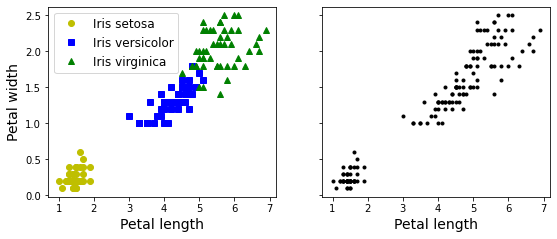

In [2]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

#save_fig("classification_vs_clustering_plot")
plt.show()

- **Figura de la izquierda:** Es un conjunto de datos etiquetado, para el cual los algoritmos de clasificación como Regresión logística, SVM o clasificadores de bosque aleatorio son muy adecuados.
- **Figura de la derecha:** Tenemos el mismo conjunto de datos, pero sin las etiquetas, por lo que ya no puede usar un algoritmo de clasificación.

- Los algoritmos de conglomerados (clustering) buscan extraer grupos homogeneos de datos usando solo las características de entrada.

In [3]:
import numpy as np
from sklearn.mixture import GaussianMixture

y_pred  = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred  = np.array([mapping[cluster_id] for cluster_id in y_pred])

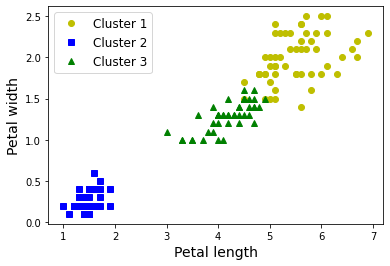

In [4]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [5]:
np.sum(y_pred==y)

0

In [6]:
np.sum(y_pred==y) / len(y_pred)

0.0

- **NOTA:** No existe una definición universal de lo que es un *clúster*: realmente depende del contexto, y diferentes algoritmos capturarán diferentes tipos de clústeres. 

- Algunos algoritmos buscan instancias centradas alrededor de un punto particular, llamado *centroide*. Otros buscan *regiones continuas de instancias densamente empaquetadas*: estos grupos pueden tomar cualquier forma.

## K-means

**Ejemplo:** Consideremos un conjunto de datos sin etiqueta representado por $5$ *blobs* de instancias/muestras. 

In [7]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y     = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Ahora observemos los *blobs*:

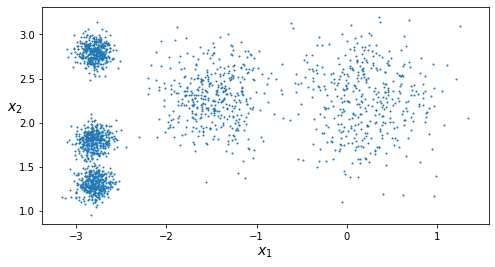

In [8]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_clusters(X)
#save_fig("blobs_plot")
plt.show()

### Ajuste y predicción

- Vamos a entrenar un *clustering K-Means* en este conjunto de datos. 

- **Intentaremos encontrar el centro de cada *blob* y asignar cada instancia al *blob* más cercano**:

In [9]:
from sklearn.cluster import KMeans
k      = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

- Tengamos en cuenta que debemos especificar el número de clústeres $k$ que debe encontrar el algoritmo. 

- En este caso, cada instancia fue asignada a uno de los 5 grupos. 

- En el contexto de la agrupación, **la etiqueta de una instancia es el índice de la agrupación a la que el algoritmo asigna esta instancia**.

- No debe confundirse con las etiquetas de clase en clasificación. 

- *KMeans* conserva una copia de las etiquetas de las instancias en las que se entrenó, disponible a través de la variable *labels_ instance*:

In [10]:
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [11]:
y_pred is kmeans.labels_

True

También podemos echar un vistazo a los 5 centroides que encontró el algoritmo:

In [12]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Por supuesto, podemos asignar fácilmente nuevas instancias al clúster cuyo centroide es el más cercano:

In [13]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

### Fronteras de decisión

Tracemos los **límites de decisión del modelo**. Esto nos da un *diagrama de Voronoi*:

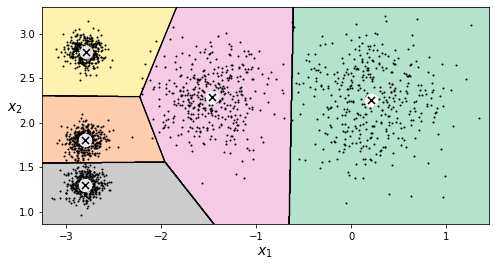

In [14]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
#save_fig("voronoi_plot")
plt.show()

- La gran mayoría de las instancias estan claramente asignadas al grupo apropiado,**pero algunas instancias probablemente estaban mal etiquetadas** (especialmente cerca del límite entre el grupo superior izquierdo y el grupo central). 
- De hecho, el algoritmo **K-Means no se comporta muy bien cuando los *blobs* tienen diámetros muy diferentes**, ya que lo único que le importa al asignar una instancia a un clúster es la distancia al centroide.

### Hard Clustering vs Soft Clustering

- En lugar de asignar cada instancia a un solo clúster, lo que se denomina *hard clustering*, puede ser útil **asignar a cada instancia una puntuación por agrupación**: esto se denomina *soft clustering*. 

- **Ejemplo:** el puntaje puede ser la distancia entre la instancia y el centroide o, por el contrario, puede ser un puntaje de similitud (o afinidad) como la Función de Base Radial Gaussiana. En la clase *KMeans*, el método *transform()* mide la distancia desde cada instancia a cada centroide:

In [15]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

### K-Means

**El algoritmo en acción:**

- La clase *KMeans* aplica un algoritmo optimizado por defecto. Para obtener el algoritmo K-Means original (solo con fines educativos), debe establecer *init="random"*, *n_init = 1* and *algorithm="full"*. Estos hiperparámetros se explicarán a continuación.

- Ejecutemos el algoritmo K-Means para 1, 2 y 3 iteraciones, para ver **cómo se mueven los centroides**:

In [16]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=5, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=10, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=10, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

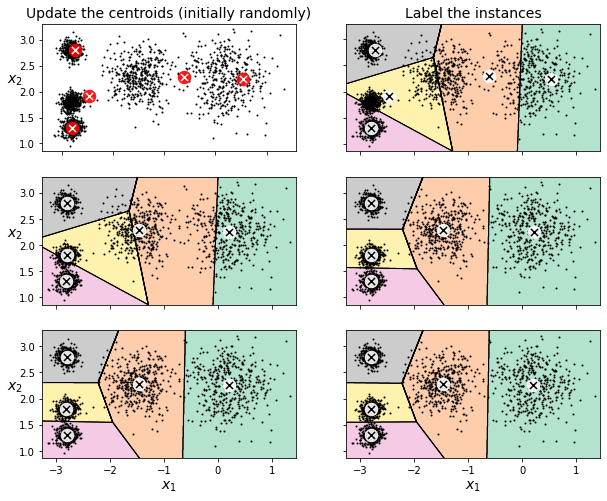

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

#save_fig("kmeans_algorithm_plot")
plt.show()

- Podemos ver el algoritmo en acción en la Figura anterior, los centroides se inicializan aleatoriamente (arriba a la izquierda). 
- Luego las instancias se etiquetan (arriba a la derecha). 
- Luego los centroides se actualizan (centro a la izquierda).
- Seguido, las instancias se vuelven a etiquetar (centro a la derecha ), y así. 

- **NOTA:** La complejidad computacional del algoritmo es generalmente lineal con respecto al número de instancias, el número de clústeres $k$ y el número de dimensiones. 

- Sin embargo, esto solo es cierto cuando los datos tienen una estructura de agrupamiento. Si no es así, entonces, en el peor de los casos, la complejidad puede aumentar exponencialmente con el número de instancias. 

### Variabilidad K-Means

**Ejemplo:** la siguiente Figura muestra dos soluciones subóptimas con las que el algoritmo puede converger si no tiene suerte con el paso de inicialización aleatoria:

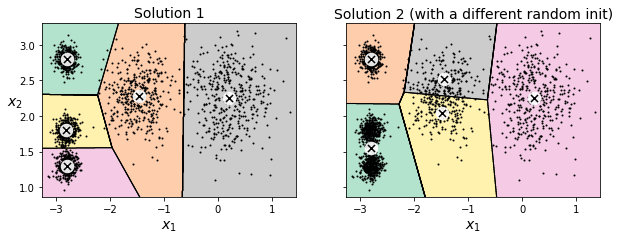

In [18]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=190)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

#save_fig("kmeans_variability_plot")
plt.show()

**Veamos algunas formas en que puede mitigar este riesgo mejorando la inicialización del centroide.**

### Métodos de inicialización de centroides

Si sabemos aproximadamente dónde deberían estar los centroides (por ejemplo, si ejecutó otro algoritmo de agrupación anteriormente), puede establecer el hiperparámetro *init* en una matriz NumPy que contiene la lista de centroides y establecer *n_init* en 1:

In [19]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans    = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True,
       init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       max_iter=300, n_clusters=5, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=42, tol=0.0001, verbose=0)

- Otra solución es **ejecutar el algoritmo varias veces con diferentes inicializaciones aleatorias y retonar la mejor solución**. 

- Esto se controla mediante el hiperparámetro *n_init*: de forma predeterminada, es igual a 10, lo que significa que todo el algoritmo descrito anteriormente se ejecuta 10 veces cuando se llama al método *fit()*, y Scikit-Learn mantiene la mejor solución.

- Pero, **¿cómo sabe exactamente cuál solución es la mejor?** 

- K-means utiliza una métrica de rendimiento llamada *inercia del modelo*: esta es la distancia cuadrática media entre cada instancia y su centroide más cercano.

In [20]:
kmeans.inertia_

211.5985372581684

- El método *score()* devuelve la inercia negativa. ¿Por qué negativo? **porque el método *score()* de un predictor siempre debe respetar la regla, a mayor valor mejor**.

In [21]:
kmeans.score(X)

-211.59853725816856

### Múltiples inicializaciones

- Un enfoque para resolver el problema de la variabilidad es **simplemente ejecutar el algoritmo K-Means varias veces con diferentes inicializaciones aleatorias y seleccionar la solución que minimice la inercia**. 

- **Ejemplo:** tenemos las inercias de los dos modelos *"malos"* que se muestran en la figura anterior:

In [22]:
kmeans_rnd_init1.inertia_

211.59853725816822

In [23]:
kmeans_rnd_init2.inertia_

238.7525191353946

- Cuando configuramos el hiperparámetro *n_init*, Scikit-Learn ejecuta el algoritmo original *n_init* veces y selecciona la solución que minimiza la inercia. Por defecto, Scikit-Learn establece *n_init = 10*.

In [24]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

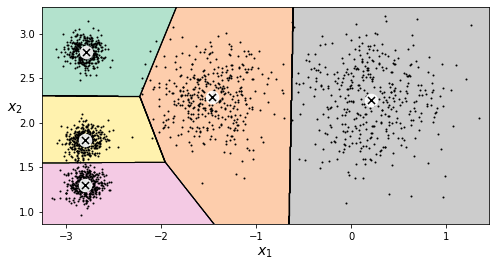

In [25]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Para establecer la inicialización en K-Means ++, simplemente se configura *init="k-means ++"* (esto es realmente el valor predeterminado):

In [26]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Accelerated K-Means

- Para usar la variante K-Means de **Elkan**, simplemente configure *algorithm = "elkan"*. 

- Tenga en cuenta que no admite datos dispersos, por lo que, de forma predeterminada, Scikit-Learn usa "*elkan*" para datos densos y "*full*" (el algoritmo K-Means normal) para datos ralos.

In [27]:
%timeit -n 20 KMeans(algorithm="elkan").fit(X)

20 loops, best of 5: 86.3 ms per loop


In [28]:
%timeit -n 20 KMeans(algorithm="full").fit(X)

20 loops, best of 5: 124 ms per loop


### Mini-Batch K-Means

Scikit Learn implementa este algoritmo en la clase *MiniBatchKMeans*. Puede usar esta clase como la clase *KMeans*:

In [29]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [30]:
minibatch_kmeans.inertia_

211.93186531476775

Si el conjunto de datos no cabe en la memoría RAM, la opción más simple es usar la clase *memmap*.

**Ejemplo:** Primero carguemos la base de datos de dígitos escritos a mano MNIST:

In [ ]:
import urllib
import os
from sklearn.datasets import fetch_openml

mnist        = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

A continuación, escribámoslo en un *memmap*:

In [ ]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'my_mnist.data')
X_mm     = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:]  = X_train

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

Si nuestros datos son tan grandes que no puede usar *memmap*, las cosas se vuelven más complicadas. Comencemos escribiendo una función para cargar el próximo lote (en la vida real, cargaría los datos desde disco duro):

In [ ]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Ahora podemos entrenar al modelo al alimentarlo un batch a la vez. También necesitamos implementar múltiples inicializaciones y mantener el modelo con la menor inercia:

In [ ]:
np.random.seed(42)

k            = 5
n_init       = 10
n_iterations = 100
batch_size   = 100
init_size    = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

best_kmeans.score(X)

**Mini-batch K-Means es mucho más rápido que los K-Means normales**:

In [ ]:
%timeit KMeans(n_clusters=5).fit(X)

In [ ]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

- **¡Eso es mucho más rápido!** Sin embargo, su rendimiento es a menudo más bajo (mayor inercia), y se sigue degradando a medida que aumenta $k$. 

- Tracemos la relación de inercia y la relación de tiempo de entrenamiento entre K-Means Mini-batch y K-Means regulares:

In [ ]:
from timeit import timeit

times    = np.empty((25, 2))
inertias = np.empty((25, 2))
for k in range(1, 26):
    kmeans_          = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 25), end="")
    times[k-1, 0]    = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]    = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 26), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 26), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 26, 0, 200])

plt.subplot(122)
plt.plot(range(1, 26), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 26), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
#plt.axis([1, 26, 0, 25])

#save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

# Cómo encontrar el número de grupos?

**Ejemplo:** como podemos ver a continuación, establecer $k$ en 3 o 8 da como resultado modelos bastante malos:

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
#save_fig("bad_n_clusters_plot")
plt.show()

- **TIP:** Quizás estemos pensando que podríamos **elegir el modelo con la menor inercia**. 

- **Respuesta:** Lamentablemente, no es tan simple. La inercia no es una buena medida de rendimiento cuando se trata de elegir $k$, ya que sigue disminuyendo a medida que aumentamos $k$. De hecho, cuantos más grupos haya, más cerca estará cada instancia de su centroide más cercano.

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias     = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
#save_fig("inertia_vs_k_plot")
plt.show()

- Como podemos ver, la inercia cae muy rápidamente a medida que aumentamos $k$ hasta 4, pero luego disminuye mucho más lentamente a medida que seguimos aumentando $k$. 
- Esta curva tiene aproximadamente la forma de un brazo, y hay un "*codo*" en $k = 4$, por lo que si no lo supiéramos mejor, sería una buena opción: cualquier valor más bajo sería dramático, mientras que cualquier valor más alto no ayudaría mucho. 

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Para calcular el *silhouette score*, puede usar la función *silhouette_score()* de Scikit-Learn, dándole todas las instancias en el conjunto de datos y las etiquetas que se les asignaron.

Tracemos la puntuación de la silueta en función de $k$:

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

Comparemos los puntajes de silueta para diferentes números de grupos:

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

Como podemos ver, esta visualización es mucho más rica que la anterior: en particular, aunque **confirma que $k = 4$ es una muy buena opción, también subraya el hecho de que $k = 5$ también es bastante bueno y mucho mejor que $k = 6$ o $k = 7$**. Esto no era visible al comparar inercias.

Adicionalmente, obtenemos una visualización aún más informativa cuando trazamos el *silhouette score* de cada instancia, ordenado por el grupo al que están asignados y por el valor del coeficiente. Esto se llama **diagrama de silueta**:

In [ ]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred                  = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos     = padding
    ticks   = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

#save_fig("silhouette_analysis_plot")
plt.show()

- Las líneas discontinuas verticales representan el *silhouette score* para cada  grupos. 
- Cuando la mayoría de las instancias en un grupo tienen un coeficiente más bajo que este puntaje (es decir, si muchas de las instancias se detienen cerca de la línea punteada, terminando a la izquierda de la misma), entonces **el grupo es bastante malo ya que esto significa que sus instancias son demasiado cerca de otros grupos**. 
- Podemos ver que cuando $k = 3$ y cuando $k = 6$, obtenemos grupos defectuosos. Pero cuando $k = 4$ o $k = 5$, los grupos se ven bastante bien: **la mayoría de los casos se extienden más allá de la línea discontinua, a la derecha y más cerca de 1.0**.
- Cuando $k = 4$, el grupo en el índice 1 (el tercero desde la parte superior), es bastante grande, mientras que cuando $k = 5$, todos los grupos tienen tamaños similares, por lo que a pesar de que la puntuación de silueta general de $k = 4$ es ligeramente mayor que para $k = 5$, parece una buena idea usar $k = 5$ para obtener **grupos de tamaños similares**.

### Consideraciones sobre K-Means

**Ejemplo:** la Figura a continuación muestra cómo KMeans agrupa un conjunto de datos que contiene tres grupos elipsoidales de diferentes dimensiones, densidades y orientaciones:

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1     = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2     = X2 + [6, -8]
X      = np.r_[X1, X2]
y      = np.r_[y1, y2]

plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad  = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

#save_fig("bad_kmeans_plot")
plt.show()

Como podemos ver, **ninguna de estas soluciones es buena**. 

- La solución a la izquierda es mejor, pero aún corta el $25\%$ del grupo intermedio y lo asigna al grupo a la derecha. 
- La solución a la derecha es simplemente terrible, a pesar de que su inercia es menor. 

Entonces, dependiendo de los datos, los diferentes algoritmos de agrupación pueden funcionar mejor. Por ejemplo, en estos tipos de grupos elípticos, los **modelos de mezcla gaussiana** funcionan muy bien.

**TIP:** Es importante **escalar las características de entrada antes de ejecutar K-Means**, de lo contrario, los grupos pueden estar muy extendidos y K-Means funcionará mal. Escalar las características no garantiza que todos los clústeres sean agradables y esféricos, pero generalmente mejora las cosas.

## Aplicación #1: Segmentación de imágenes

Aquí, vamos a hacer algo mucho más simple: **segmentación de color**. Simplemente asignaremos píxeles al mismo segmento si tienen un color similar. Primero, carguemos la imagen usando la función *imread()* de Matplotlib:

In [ ]:
FILEID = "1BlSBya5x9Jsd1Bu-6PPwMehdPQgAkX0w"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ladybug.png && rm -rf /tmp/cookies.txt



In [ ]:
from matplotlib.image import imread
image = imread(os.path.join("ladybug.png"))
plt.imshow(image)
image.shape

- La imagen se representa como una **matriz 3D**: el tamaño de la primera dimensión es la altura, el segundo es el ancho y el tercero es el número de canales de color, en este caso rojo, verde y azul (RGB). En otras palabras, para cada píxel hay un vector 3D que contiene las intensidades de rojo, verde y azul, cada una entre 0.0 y 1.0 (o entre 0 y 255 si usa *imageio.imread ()*). 
- Algunas imágenes pueden tener menos canales, como imágenes en escala de grises (un canal), o más canales, como imágenes con un canal alfa adicional para transparencia, o imágenes de satélite que a menudo contienen canales para muchas frecuencias de luz (por ejemplo, infrarrojos). 

El siguiente código da nueva forma a la matriz para obtener una larga lista de colores RGB, luego agrupa estos colores usando K-Means. 

**Ejemplo:**
1. Identificar un grupo de colores para todos los tonos de verde. 
2. A continuación, para cada color (por ejemplo, verde oscuro), busca el color medio del grupo de colores del píxel. Por ejemplo, todos los tonos de verde pueden reemplazarse con el mismo color verde claro (suponiendo que el color medio del grupo verde sea verde claro). 
3. Finalmente, dar nueva forma a esta larga lista de colores para obtener la misma forma que la imagen original. ¡Y hemos terminado!.

In [ ]:
X             = image.reshape(-1, 3)
kmeans        = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
plt.imshow(segmented_img)

Podemos experimentar con varios números de grupos, como se muestra en la siguiente figura. 

In [ ]:
segmented_imgs = []
n_colors       = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans        = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

#save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

- Cuando usamos menos de 8 grupos, observamos que el llamativo color rojo de la mariquita no consigue un grupo propio: se fusiona con los colores del entorno. Esto se debe al hecho de que la mariquita es bastante pequeña, mucho más pequeña que el resto de la imagen, por lo que a pesar de que su color es llamativo, K-Means no puede dedicarle un grupo: como se mencionó anteriormente, **K-Means prefiere grupos de tamaños similares**.

## Application #2: Using clustering for preprocessing

Clustering puede ser un enfoque eficiente para la reducción de la dimensionalidad, en particular **como un paso de preprocesamiento antes de un algoritmo de aprendizaje supervisado**. 

**Ejemplo:** Abordemos el conjunto de datos de dígitos, que es un conjunto de datos simple similar a MNIST que contiene 1.797 imágenes en escala de grises $8\times 8$ que representan dígitos del 0 al 9. Primero, carguemos el conjunto de datos:

In [ ]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

Ahora, dividámoslo en un conjunto de entrenamiento y un conjunto de prueba:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

A continuación, ajustemos un modelo de **Regresión logística**:

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

Vamos a evaluar su precisión en el conjunto de prueba:

In [ ]:
log_reg.score(X_test, y_test)

Bien, esa es nuestra línea de base: **96.7% de precisión**. Veamos si podemos mejorar utilizando KMeans como un paso de preprocesamiento. Crearemos un *pipeline* que:
1. Primero agrupará el conjunto de entrenamiento en 50 grupos
2. Luego, reemplazaremos las imágenes con sus distancias a estos 50 grupos
3. Por último, aplicaremos un modelo de regresión logística.

**NOTA:** Aunque es tentador definir el número de grupos a 10, dado que hay 10 dígitos diferentes, es poco probable que funcione bien, porque **hay varias formas diferentes de escribir cada dígito**.

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Ahora vamos a evaluar esta tubería de clasificación:

In [ ]:
pipeline.score(X_test, y_test)

In [ ]:
1 - (1 - 0.977777) / (1 - 0.968888)

¿Qué hay sobre eso? ¡Redujimos la tasa de error en más del 28%! 
- Sin embargo, elegimos el número de clústeres $k$ completamente arbitrariamente, seguramente podemos hacerlo mejor. 
- Dado que K-Means es solo un paso de preprocesamiento en el *pipeline* de clasificación, encontrar un buen valor para $k$ es mucho más simple que antes: no es necesario realizar un análisis de silueta o minimizar la inercia, el mejor valor de $k$ es simplemente el uno que resulte en el mejor rendimiento de clasificación.
Usemos *GridSearchCV* para encontrar la cantidad óptima de clústeres:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf   = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Veamos el mejor valor para $k$ y el rendimiento del *pipeline* resultante:

In [ ]:
grid_clf.best_params_

In [ ]:
grid_clf.score(X_test, y_test)

Con $k = 99$ grupos, obtenemos un pequeño aumento de precisión, alcanzando un 98,2% de precisión en el conjunto de prueba. ¡Bueno!

## Application #3: Using clustering for semi-supervised learning

Otro caso de uso para clustering es en el aprendizaje semi-supervisado **cuando tenemos muchas instancias sin etiquetar y muy pocas instancias etiquetadas**. Vamos a entrenar un modelo de regresión logística en una muestra de 50 instancias etiquetadas del conjunto de datos de dígitos:

In [ ]:
n_labeled = 50
log_reg   = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

¿Cuál es el rendimiento de este modelo en el conjunto de prueba?

In [ ]:
log_reg.score(X_test, y_test)

- La precisión es solo del $83.3\%$: no debería sorprendernos que esto sea mucho más bajo que antes cuando entrenamos el modelo en el conjunto de entrenamiento completo. 
- Veamos cómo podemos hacerlo mejor:
    1. Agrupemos el conjunto de entrenamiento en 50 grupos
    2. Para cada grupo, busquemos la imagen más cercana al centroide. Llamaremos a estas imágenes imágenes representativas:

In [ ]:
k                        = 50
kmeans                   = KMeans(n_clusters=k, random_state=42)
X_digits_dist            = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits  = X_train[representative_digit_idx]

Ahora tracemos estas imágenes representativas y rotúlemoslas manualmente:

In [ ]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

#save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [ ]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Ahora tenemos un conjunto de datos con solo 50 instancias etiquetadas, pero en lugar de ser instancias completamente aleatorias, **cada una de ellas es una imagen representativa de su clúster**. Veamos si el rendimiento es mejor:

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

**¡Guauu! Saltamos del 82.7% de precisión al 92.4%**, aunque todavía solo estamos entrenando el modelo en 50 instancias. Dado que a menudo es costoso y doloroso etiquetar instancias, especialmente cuando los expertos deben hacerlo manualmente, es una buena idea **etiquetar instancias representativas en lugar de solo instancias aleatorias**.

Pero tal vez podamos ir un paso más allá: **¿qué pasa si propagamos las etiquetas a todas las demás instancias en el mismo clúster?** Esto se llama *propagación de etiquetas*:

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

In [ ]:
log_reg.score(X_test, y_test)

- Obtuvimos un pequeño aumento de precisión. Mejor que nada, pero no asombroso. 
- El problema es **que propagamos la etiqueta de cada instancia representativa a todas las instancias en el mismo clúster, incluidas las instancias ubicadas cerca de los límites del clúster, que tienen más probabilidades de estar mal etiquetadas**. 

Veamos qué sucede si solo propagamos las etiquetas al $20\%$ de las instancias más cercanas a los centroides:

In [ ]:
percentile_closest = 20
X_cluster_dist     = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster      = (kmeans.labels_ == i)
    cluster_dist    = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff    = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated         = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

In [ ]:
log_reg.score(X_test, y_test)

¡Excelente! Con solo 50 instancias etiquetadas (¡solo 5 ejemplos por clase en promedio!), Obtuvimos un rendimiento del 94.2%, que está bastante cerca del rendimiento de la regresión logística en el conjunto de datos de dígitos completamente etiquetados (que fue del 96.7%). **Esto se debe a que las etiquetas propagadas son bastante buenas, su precisión es muy cercana al 99%**:

In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

## DBSCAN

La clase **DBSCAN** en Scikit-Learn es tan simple de usar como cabría esperar. Probémoslo en el conjunto de datos de lunas:

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

Las etiquetas de todas las instancias ahora están disponibles en la variable *labels_ instance*:

In [ ]:
dbscan.labels_[:10]

Tenga en cuenta que algunas instancias tienen un índice de clúster igual a **-1**: esto significa que **el algoritmo las considera anomalías**. Los índices de las instancias centrales están disponibles en la variable de instancia *core_sample_indices_*, y las propias instancias centrales están disponibles en la variable *components_ instance*:

In [ ]:
len(dbscan.core_sample_indices_)

In [ ]:
dbscan.core_sample_indices_

In [ ]:
dbscan.components_[:3]

In [ ]:
import numpy as np
np.unique(dbscan.labels_)

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

#save_fig("dbscan_plot")
plt.show()

Este agrupamiento se representa en la gráfica izquierda de la figura. 
- Como podemos ver, el algoritmo identificó bastantes anomalías, además de 7 grupos diferentes. **¡Que decepcionante!**.

Afortunadamente, si **ampliamos el vecindario de cada instancia** al aumentar $\epsilon$ a 0.2, obtenemos el agrupamiento a la derecha, que se ve perfecto. Continuemos con este modelo.

Sorprendentemente, la clase **DBSCAN** no tiene un método *predict_()*, aunque tiene un método *fit_predict_()*. En otras palabras, no puede predecir a qué clúster pertenece una nueva instancia. La razón de esta decisión es que varios algoritmos de clasificación podrían tener sentido aquí, y es bastante fácil entrenar uno, por ejemplo, un clasificador K-NN:

In [ ]:
dbscan = dbscan2

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

- Ahora, dadas algunas instancias nuevas, **podemos predecir a qué grupo probablemente pertenecerán**, e incluso **estimar una probabilidad para cada grupo**. 
- Tengamos en cuenta que solo los entrenamos en las instancias centrales, pero también podríamos haber optado por capacitarlos en **todas las instancias**, o **todas menos las anomalías**: esta elección depende de la tarea final.

In [ ]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

In [ ]:
knn.predict_proba(X_new)

In [ ]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
#save_fig("cluster_classification_plot")
plt.show()

El límite de decisión se representa en la Figura anterior:
- Las cruces representan las 4 instancias en *X_new*. 
- Tengamos en cuenta que, dado que no hay ninguna anomalía en el conjunto de entrenamiento del KNN, **el clasificador siempre elige un grupo, incluso cuando ese grupo está muy lejos**. 

Sin embargo, es bastante sencillo introducir una *distancia máxima*, en cuyo caso **las dos instancias que están lejos de ambos grupos se clasifican como anomalías**. Para hacer esto, podemos usar el método de los *kneighbors()* del **KNeighsClassifier**: dado un conjunto de instancias, devuelve las distancias y los índices de los $k$ vecinos más cercanos en el conjunto de entrenamiento (dos matrices, cada una con $k$ columnas):

In [ ]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

## Otros algoritmos de clustering

### Spectral clustering

In [ ]:
from sklearn.cluster import SpectralClustering
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

In [ ]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

In [ ]:
np.percentile(sc1.affinity_matrix_, 95)

In [ ]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()